# E3 Parallel Programming with Python

## Instructions:

Compute 𝜋via numericla integration. We use the fact that 𝜋is the áreaof the unit circle, and we approximate this by computing the áreaof a quarter circle using Riemann sums:

- Let 𝑓(𝑥)=√1−𝑥^2 be the function that describes the quarter circle for x = 0, ..., 1;
- Then we compute:
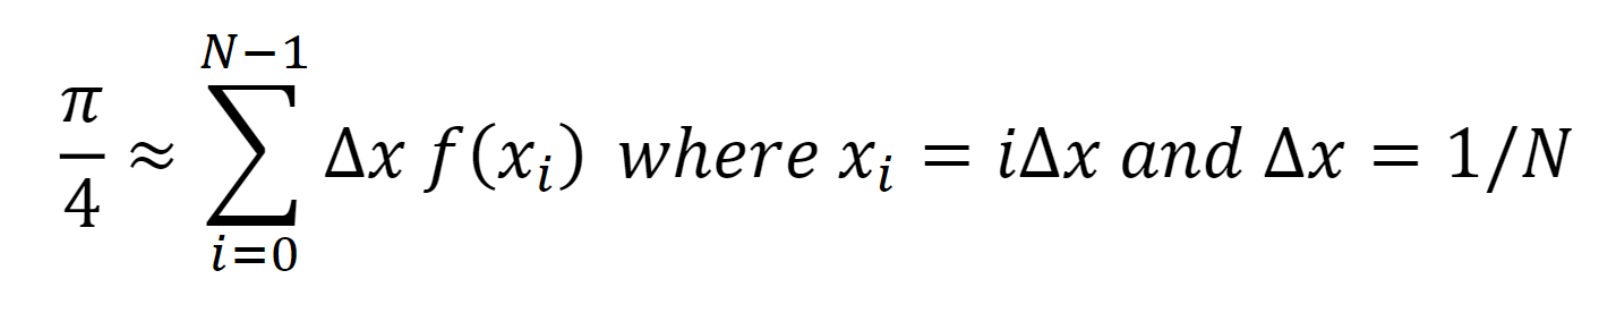


Write a program which uses the previous strategy to obtain 𝜋 via numericla integration:

1. Write a program in Python which solves the program without any parallelization.
2. Write a program in Python which uses parallel computing via multiprocessing to solve the problem.
3. Write a program in Python which uses distributed parallel computing via mi4py to solve the problem.

## Solving without any parallelization

In [ ]:
import numpy as np

In [ ]:
# Define the function to integrate
def f(x):
    return np.sqrt(1 - x**2)

# Define the numerical integration function using Riemann sums
def compute_pi(N):
    riemann_sum = 0 # Initialize the sum
    delta_x = 1 / N # Compute Δx

    # Compute the sum
    for i in range(N):
        xi = i * delta_x
        riemann_sum += f(xi) * delta_x

    # Multiply by 4 to get the approximation of π
    return riemann_sum * 4

# Number of rectangles
N = 100000  # Using a large N for a better approximation

# Compute π
pi_approximation = compute_pi(N)
print(f"Approximation of pi: {pi_approximation}")

Approximation of pi: 3.1416126164019564


### Profiling

In [ ]:
import time

In [ ]:
# Function to profile the compute_pi function for different values of N
def profile_compute_pi(N_values):
    times = []
    for N in N_values:
        start_time = time.time()
        compute_pi(N)
        end_time = time.time()
        times.append(end_time - start_time)
    return times

# Different values of N to evaluate the execution time
N_values = [10**k for k in range(1, 7)]

# Profile the function
execution_times = profile_compute_pi(N_values)


def display_execution_times(N_values, execution_times):
    for N, time in zip(N_values, execution_times):
        print(f"For N = {N:,}, the execution time was approximately {time:.6f} seconds.")

display_execution_times(N_values, execution_times)

For N = 10, the execution time was approximately 0.000061 seconds.
For N = 100, the execution time was approximately 0.000206 seconds.
For N = 1,000, the execution time was approximately 0.002332 seconds.
For N = 10,000, the execution time was approximately 0.028887 seconds.
For N = 100,000, the execution time was approximately 0.224685 seconds.
For N = 1,000,000, the execution time was approximately 2.259626 seconds.


## Solving with parallel computing

In [ ]:
import numpy as np
from math import sqrt
from multiprocessing import Pool

In [ ]:
# Define the function to integrate
def f(x):
    return sqrt(1 - x**2)

# The integrand for the Riemann sum in the interval
def integrand(i, delta_x):
    x = i * delta_x
    return f(x) * delta_x

# Compute pi using numerical integration
def compute_pi(n_intervals):
    delta_x = 1 / n_intervals
    indices = range(n_intervals)
    with Pool() as pool:
        results = pool.starmap(integrand, [(i, delta_x) for i in indices])
    return 4 * sum(results)

# Number of intervals
n_intervals = 100000  # You can increase this number for a more accurate result

# Calculate pi
pi_approximation = compute_pi(n_intervals)
print(f"Approximation of pi: {pi_approximation}")

Approximation of pi: 3.1416126164019564


### Profiling

In [ ]:
import time

In [ ]:
# Profiling function
def profile_computation(n_values):
    times = []
    for n_intervals in n_values:
        start_time = time.time()
        compute_pi(n_intervals)
        end_time = time.time()
        times.append(end_time - start_time)
        print(f"N = {n_intervals} took {end_time - start_time:.4f} seconds")
    return times

# Range of N values to profile
n_values = [1000, 10000, 100000, 1000000]

# Profile the compute_pi function
profile_computation(n_values)

N = 1000 took 0.0279 seconds
N = 10000 took 0.0334 seconds
N = 100000 took 0.1277 seconds
N = 1000000 took 1.0931 seconds


[0.027869224548339844,
 0.03340935707092285,
 0.12768912315368652,
 1.0931406021118164]

## Solving with distributed parallel computing

In [ ]:
!pip install mpi4py

In [ ]:
import math
from mpi4py import MPI

In [ ]:
def calculate_part_of_pi(N, rank, size):
    # Calculates a portion of PI based on the rank of the process and total number of processes.
    # Uses a numerical integration method over a quarter circle.
    dx = 1.0 / N
    local_sum = sum(dx * math.sqrt(1 - (i * dx) ** 2) for i in range(rank, N, size))
    return local_sum

def distributed_calculate_pi(N):
    # Calculates the approximation of PI using multiple processes distributed across MPI.
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    local_sum = calculate_part_of_pi(N, rank, size)
    pi_approx = 4 * comm.reduce(local_sum, op=MPI.SUM, root=0)

    if rank == 0:
        print(f"Approximation of pi: {pi_approx}")

if __name__ == "__main__":
    N = 10000
    distributed_calculate_pi(N)

Approximation of pi: 3.1417914776113167


### Profiling

In [28]:
import cProfile

In [ ]:
def profile_function(func, *args):
    #Profiles the specified function using cProfile, without printing results from the function itself.
    profiler = cProfile.Profile()
    profiler.enable()
    func(*args)  # Execute the function with the provided arguments.
    profiler.disable()
    if MPI.COMM_WORLD.Get_rank() == 0:  # Ensure only the root process prints the profiling stats
        profiler.print_stats(sort='time')

if __name__ == "__main__":
    N = 10000
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    if rank == 0:
        print("Starting profiling of distributed PI calculation.")
    profile_function(distributed_calculate_pi, N)  # Profile on all nodes, but only the root node will print profiling stats.

Starting profiling of distributed PI calculation.
Approximation of pi: 3.1417914776113167
         20035 function calls in 0.009 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10001    0.006    0.000    0.007    0.000 <ipython-input-22-aa7629d24a1e>:5(<genexpr>)
        1    0.001    0.001    0.008    0.008 {built-in method builtins.sum}
    10000    0.001    0.000    0.001    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.009    0.009 <ipython-input-22-aa7629d24a1e>:8(distributed_calculate_pi)
        1    0.000    0.000    0.000    0.000 {method 'reduce' of 'mpi4py.MPI.Comm' objects}
        2    0.000    0.000    0.000    0.000 socket.py:543(send)
        2    0.000    0.000    0.000    0.000 iostream.py:384(write)
        2    0.000    0.000    0.000    0.000 iostream.py:195(schedule)
        1    0.000    0.000    0.008    0.008 <ipython-input-22-aa7629d24a1e>:1(calculate_part_of_pi)
        2 